In [33]:
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime
import os
from tqdm import tqdm_notebook as tqdm
%config InlineBackend.figure_format = 'retina'
import numpy as np
import re
import math
from pandas import Series
import pandas
import wikipediaapi
import csv
from tqdm import tqdm
from urllib.parse import unquote
import wikipedia
import matplotlib
from scipy import stats
from pydoc import help
from scipy.stats.stats import pearsonr
import seaborn as sns

In [ ]:
def get_language_distribution(file_name, language):

    for line in tqdm(open(file_name)):
        out = re.findall('[http|https]://([a-z]{2,3}).',line)[0]
        if out=='www':
            continue
        if out in language:
            language[out] += 1
        else:
            language[out] = 1
    return language
language = {}
path = "./data/only_lemma/"  
files= os.listdir(path)
for line in files:
    language=get_language_distribution('./data/only_lemma/%s'%line, language)
# langaue is a dictionary 'language':counts

In [3]:
# sort the language
f = zip(language.values(),language.keys())
out = sorted(f,reverse=True)
number = list([math.log(item[0]) for item in out])
name = list([item[1] for item in out])

In [ ]:
number.dump('./data/languagenumber')
name.dump('./data/languageName')

In [4]:
def get_langlinks(tokens):
    tokens=unquote(tokens, 'utf-8') 
    wiki_wiki = wikipediaapi.Wikipedia('en')
    page_py = wiki_wiki.page(tokens)
    langlinks = page_py.langlinks.keys()
    return langlinks

def get_langCount(tokenlist):
    LangCount=np.array(np.zeros((len(tokenlist))))
    for i in tqdm(range(len(tokenlist))):
        try:
            LangCount[i]=len(get_langlinks(tokenlist[i]))
        except:
            continue
    return LangCount

In [ ]:
hotwords=pandas.read_csv('./data/revisions/hot_10000.csv',sep='	')
hotwords.sort_values(by=['frequency'],ascending=False,inplace=True)
words=np.array(hotwords.iloc[1:10000,0])
LangCount=get_langCount(words)

# Hypothesis 1: The more visits of an entry, the more language choices it will have
We have totally 251 kinds of languages in our dataset. We chose the most popular 10000 words and count how many language for each entry has.

Log(Number of language choice) v.s. total access of this language. Pearson correlation coefficient for these two variables is 0.997 and 2-tailed p-value is 4.8e-10


/home/xuanli2/penv/lib/python3.5/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/home/xuanli2/penv/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


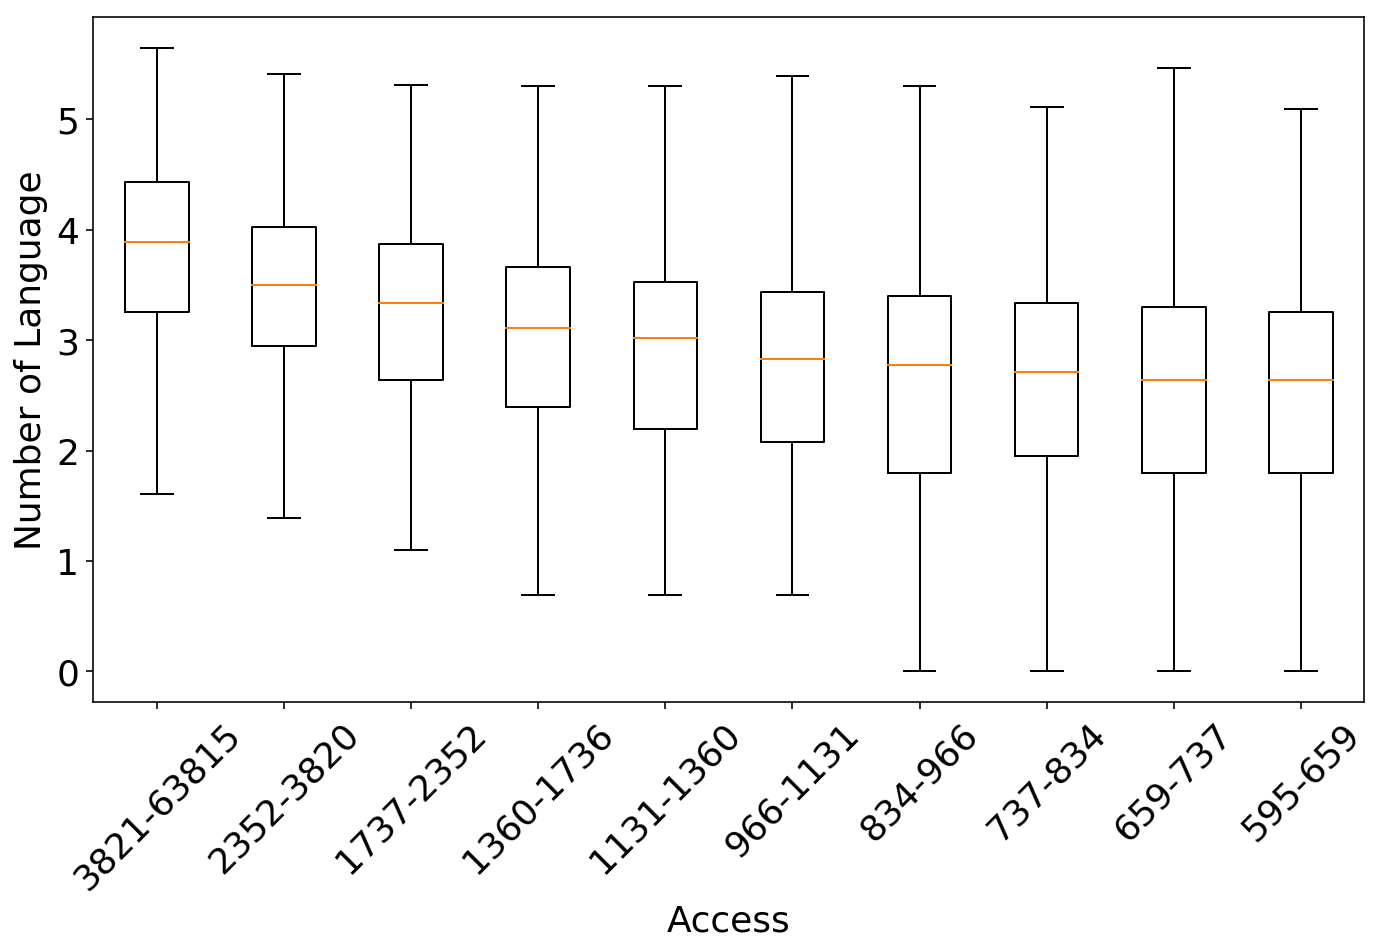

(0.9967607852845005, 4.797863337882628e-10)

<Figure size 432x288 with 0 Axes>

In [96]:
#plot the curve 
fig = plt.figure(figsize=(10,7))
matplotlib.rcParams.update({'font.size': 18})
name=np.load('./data/languageName')
number=np.load('./data/languagenumber')
language=np.load('./data/WordsLanguageCounts')

hotwords=pandas.read_csv('./data/revisions/hot_10000.csv',sep='	')
hotwords.sort_values(by=['frequency'],ascending=False,inplace=True)
access=np.zeros((9999,))
for i in range(9999):
    access[i]=hotwords['frequency'].iloc[1+i]

data = []
xlabels = []
for j in range(10):
    if j==9:
        partnumber = np.log(language[j*1000:9999])
        partaccess = access[j*1000:9999]
    else:
        partnumber = np.log(language[j*1000:1000*(j+1)])
        partaccess = access[j*1000:1000*(j+1)]
    data.append(partnumber)
    xlabels.append("{}-{}".format(int(min(partaccess)),int(max(partaccess))))
plt.boxplot(data,0, '')
plt.xticks(range(1,11), xlabels)
plt.ylabel("Number of Language")
plt.xlabel("Access")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.tight_layout()
plt.show()
plt.tight_layout()
fig.savefig("plots/access-Number_of_Language-boxplot.png", dpi=400)
data = []
xlabels = []
for j in range(10):
    if j==9:
        data.append(np.log(language[j*1000:9999]+1).mean())
        xlabels.append(np.log(access[j*1000:9999]).mean())
    else:
        data.append(np.log(language[j*1000:1000*(j+1)]+1).mean())
        xlabels.append(np.log(access[j*1000:1000*(j+1)]).mean())
pearsonr(data,xlabels)

In [ ]:
def change_langlinks(lang,page):
    wikipedia.set_lang('en')
    langlinks = page.langlinks
    #print(langlinks.keys())
    return langlinks[lang].title

def get_PageLength(language,tokens):
    tokens=unquote(tokens, 'utf-8')
    p_wiki = wiki_wiki.page(tokens)
    try:
        NewTitle=change_langlinks(language,p_wiki)
        NewTitle=unquote(NewTitle, 'utf-8')
        wikipedia.set_lang(language)
        out=wikipedia.page(NewTitle).content
        return len(out)
    except:
        return 0   

In [ ]:
hotwords=pandas.read_csv('./data/revisions/hot_10000.csv',sep='	')
hotwords.sort_values(by=['frequency'],ascending=False,inplace=True)
name=np.load('./data/languageName')
number=np.load('./data/languagenumber')
numberofwords=100
wordslist=np.array(hotwords.iloc[1:numberofwords,0])
lengths=np.ones((len(name),numberofwords))
print('start')
for i in tqdm(range(numberofwords)):
    print(i)
    tokens=unquote(wordslist[i],'utf-8')
    wikipedia.set_lang('en')
    wiki_wiki = wikipediaapi.Wikipedia('en')
    p_wiki = wiki_wiki.page(tokens)
    langlinks = p_wiki.langlinks
    try:
        out = len(wikipedia.page(tokens).content)
    except wikipedia.exceptions.DisambiguationError as e:
        try:
            out = len(wikipedia.page(e.options[0]).content)
        except:
            out=0
    except:
            out=0
    lengths[0,i]=out
    for lang in langlinks.keys():
        if lang in name:
            NewTitle=langlinks[lang].title
            NewTitle=unquote(NewTitle, 'utf-8')
            wikipedia.set_lang(lang)
            try:
                out = len(wikipedia.page(NewTitle).content)
            except wikipedia.exceptions.DisambiguationError as e:
                try:
                    out = len(wikipedia.page(e.options[0]).content)
                except:
                    out=0
            except:
                out=0  
            index=list(name).index(lang)
            lengths[index,i]=out
            

# Hypothesis 2: Hotter languages have longer average page lengths
By using 1000 entries as samples, we calculated the the average length of each entry for each language choice.

Pearson correlation coefficient is 0.969 and 2-tailed p-value is 3.7e-6.

<Figure size 432x288 with 0 Axes>

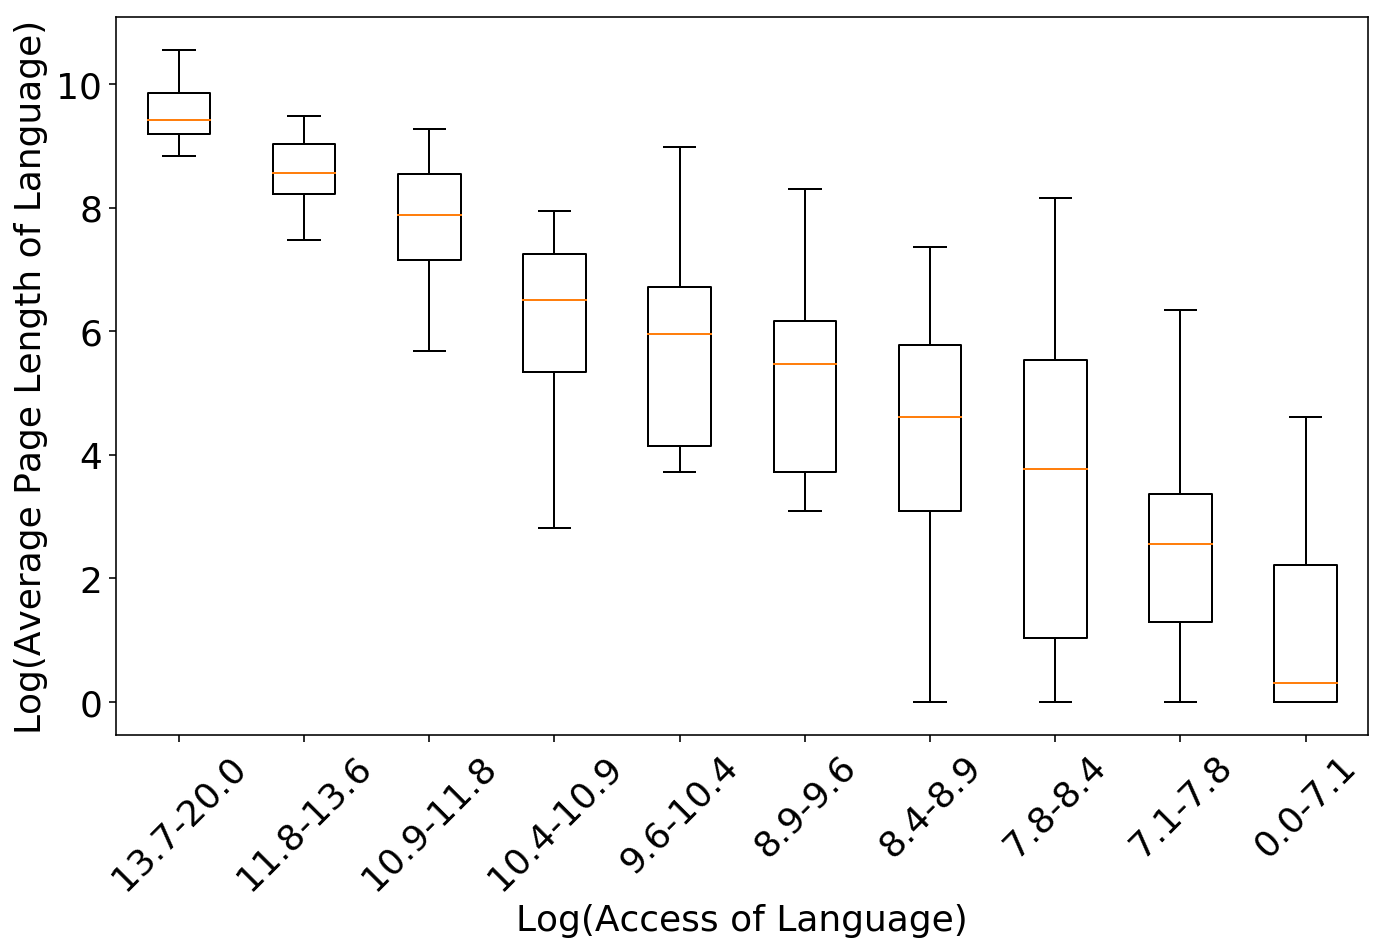

<Figure size 432x288 with 0 Axes>

In [5]:
# plot curve
fig = plt.figure()
fig = plt.figure(figsize=(10,7))
matplotlib.rcParams.update({'font.size': 18})
lengths=np.load('./data/LanLengths')
lengths=lengths.mean(1)
number=np.load('./data/languagenumber')
data = []
xlabels = []
for j in range(10):
    if j==9:
        partlengths = np.log(lengths[j*25:251])
        partnumber = number[j*25:251]
    else:
        partlengths = np.log(lengths[j*25:25*(j+1)])
        partnumber = number[j*25:25*(j+1)]
    data.append(partlengths)
    xlabels.append("{}-{}".format('{:.1f}'.format(min(partnumber)),'{:.1f}'.format(max(partnumber))))
plt.boxplot(data,0, '')
plt.xticks(range(1,11), xlabels)
plt.ylabel("Log(Average Page Length of Language)")
plt.xlabel("Log(Access of Language)")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.tight_layout()
plt.show()
plt.tight_layout()
fig.savefig("plots/Log(Average_Length_of_Language)-Log(Access_of_Language)-boxplot.png", dpi=400)


In [42]:
def mean_interval_estimation(name,lengths,index1,index2,alpha):
    data=lengths[index1]-lengths[index2]
    sample_mean = np.mean(data)
    sample_std = np.std(data)
    sample_size = len(data)
    t_score = stats.t.isf(alpha / 2, df = (sample_size-1) )
    ME = t_score * sample_std / np.sqrt(sample_size)
    lower_limit = sample_mean - ME
    upper_limit = sample_mean + ME
    print('the difference between page average length of "{}" and "{}"'.format(name[index1],name[index2]))
    print( str((1-alpha)*100)+ '%% Confidence Interval: ( %.2f, %.2f)' % (lower_limit, upper_limit))
name=np.load('./data/languageName')
lengths=np.load('./data/LanLengths')
mean_interval_estimation(name,lengths,1,13,0.05)

the difference between page average length of "ja" and "zh"
95.0% Confidence Interval: ( 2224.51, 6526.03)


In [30]:
lengths=np.load('./data/LanLengths')
lengths=lengths.mean(1)
number=np.load('./data/languagenumber')
data = []
xlabels = []
for j in range(10):
    if j==9:
        data.append(np.log(lengths[j*25:251]).mean())
        xlabels.append(number[j*25:251].mean())
    else:
        data.append(np.log(lengths[j*25:25*(j+1)]).mean())
        xlabels.append(number[j*25:25*(j+1)].mean())
pearsonr(data,xlabels)

[9.574446857140728, 8.238359126513588, 7.695321825498663, 5.988261947441086, 5.3933230965445444, 5.245709095715788, 4.36847258787239, 3.512463601761344, 2.516119036221201, 1.2034466707004368] [15.663420359375078, 12.815737278768543, 11.253649573387689, 10.662108173947763, 10.072997286674028, 9.20917218095651, 8.682458051683305, 8.143767118223668, 7.477083267191291, 6.270181163398149]


(0.9694085214835572, 3.6927258519551204e-06)

# Hypothesis 3: difference in page length is a Norm distribution
We use 'ja'(Japaneses) and 'zh'(Chinese) as example to test that the difference in page length between these two language is a normal distribution. by calculating 100 hottest entry words' page length in these two language we can obtain the results below.

After log operation for the length, it seems like this distribution fits norm distribution well and then we will try to make parameter estimation to find the details of distribution. MLE of $\mu$ of the distribution is 0.56 and $\sigma^2$ is 5.62. So, the conclusion will be:
\\[log(PageLength(ja)) - log(PageLength(zh)) \sim N(0.56,5.62)\\]

/home/xuanli2/penv/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Mean:0.56 and Var:5.62


<Figure size 432x288 with 0 Axes>

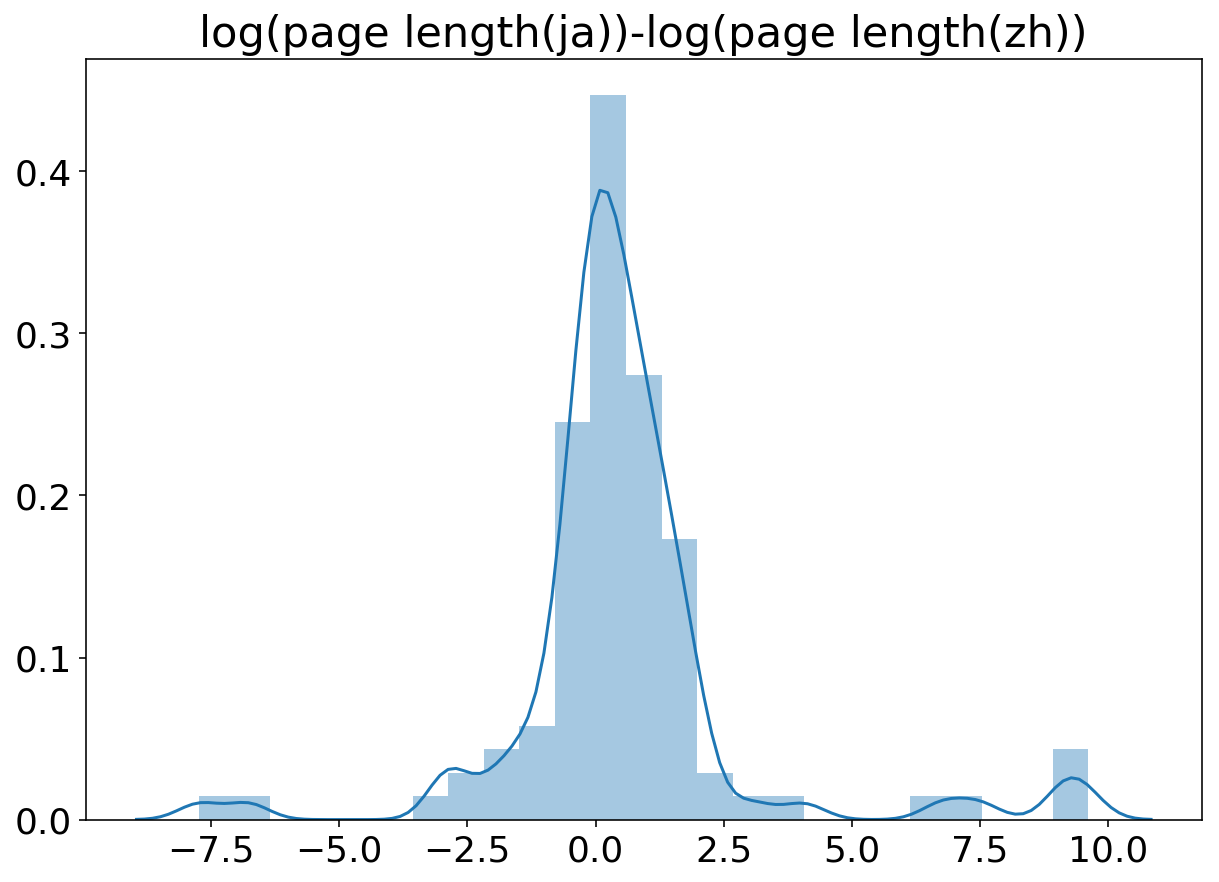

In [71]:
fig = plt.figure()
fig = plt.figure(figsize=(10,7))
matplotlib.rcParams.update({'font.size': 18})
data=np.log(lengths[1,:])-np.log(lengths[13,:])
sns.distplot(data,bins=25)
plt.title("log(page length(ja))-log(page length(zh))")
fig.savefig("plots/Close_to_Norm.png", dpi=400)
print('Mean:{:.2f} and Var:{:.2f}'.format(data.mean(),data.var()))

In [85]:
from scipy.stats import kstest
import scipy.stats as ss
from scipy.stats import ks_2samp
normal_x = np.linspace(np.min(data), np.max(data), 10000)
normal_y = ss.norm.cdf(normal_x, loc=np.mean(data), scale=np.std(data)) 
#ks_2samp(data, normal_y)
kstest(data, lambda x: ss.norm.cdf(x, loc=np.mean(data), scale=np.std(data)) )

KstestResult(statistic=0.2027454845346156, pvalue=0.0004425995571366581)